In [2]:
import torch
# Pytorch utils for neural net
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.functional as F

import numpy as np
import os 
import matplotlib.pyplot as plt

c:\Users\bdub\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class HSI_Datset(Dataset):
    #init func tells us to supply x and y with invokation
    def __init__(self, set, target):
        self.dir_str = r'C:\Users\bdub\OneDrive - Michigan State University\Nutrient Scans\Data\DataTensors'
        # Set == Train or Test, should have those folders in DataTensors
        self.set = set
        # Target is N in this case
        self.target = target
        # scans is object pointing to input CorNDVI images in set
        self.scans = os.listdir(self.dir_str + r'\\' + self.set + r'\\Scans')
        # nutes object pointing to corresponding target to predict with scans
        self.nutes = os.listdir(self.dir_str + r'\\' + self.set + r'\\' + self.target)


    # __getitem__: Loop through self.scans and return one scan and corresponding target
    def __getitem__(self, index):
        scan = self.scans[index]
        fname = scan.split('-')
        uid = fname[1]
        # concat uid and unique integer.pt id
        trunk = fname[1] + '-' + fname[2]
        # need to unsqueeze becuase of dimensions in saved tensor, could make it better
        x = torch.load(self.dir_str + r'\\' + self.set + r'\\Scans\\' + scan).unsqueeze(0)
        # should also do this step in tensor creation
        x = torch.nan_to_num(x)
        # string manipulation to load cognate target tanesor based on uid + integert id
        ypath = self.dir_str + r'\\' + self.set + r'\\' + self.target
        y = torch.load(ypath +r'\\' + self.target + '-' + trunk)
        return x, y
    
    def __len__(self):
        return len(self.scans)

In [7]:
train = HSI_Datset(set = 'Train', target = 'N')
# shuffle the training set
train_loader = DataLoader(train, batch_size=164, shuffle=True)
test = HSI_Datset(set = 'Test', target = 'N')
# batch size 166 includes all test objects
test_loader = DataLoader(test, batch_size=151, shuffle=False)

# Note on architecture and other parameters:
- very little tuning was done on the number or type of layers, optimizer type and learning rate.

In [9]:
class HSI_CNN(nn.Module):
    def __init__(self):
        super(HSI_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels = 1, kernel_size=4).double()
        self.maxpool = nn.MaxPool2d(kernel_size=4)
        # need to do math to calculate final input size for linear
        self.linear = torch.nn.Linear(3249,10).double()
        self.predict = torch.nn.Linear(10, 1).double()

    # forward defines layer architecture of cnn in sequential order
    def forward(self, x):
        x = self.cnn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = F.relu(x)
        x = self.predict(x).squeeze(0)
        return x

In [10]:
nute_net = HSI_CNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(nute_net.parameters(), lr = 0.001)

In [13]:
from torchmetrics import R2Score


e = 10
r2score = R2Score()
train_mse = []
train_r2 = []
test_mse = []
test_r2 = []

for epoch in range(e):
    for data in train_loader:
        train_mse_batch = []
        y = data[1].unsqueeze(1)
        x = data[0]
        outputs = nute_net(x)
        loss = criterion(y, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_mse_batch.append(loss.item())
        #print('MSE', loss.item())
        train_mse.append(loss.item())
        train_r2.append(r2score(outputs, y).item())
    #print('train R2:', r2score(outputs, y))
    for data in test_loader:  
        with torch.no_grad():
            y = data[1].unsqueeze(1)
            x = data[0]
            predictions = nute_net(x)
            test_loss = criterion(y, predictions)
            test_r2.append(r2score(predictions, y).item())
            test_mse.append(test_loss.item())
            #print('Val R2:', r2score(predictions, y))
    print(epoch)
    print('Val R2:', r2score(predictions, y))

0
Val R2: tensor(-0.3375)
1
Val R2: tensor(-0.4612)
2
Val R2: tensor(-0.3667)
3
Val R2: tensor(-0.3404)
4
Val R2: tensor(-0.4485)
5
Val R2: tensor(-0.4312)
6
Val R2: tensor(-0.4354)
7
Val R2: tensor(-0.4898)
8
Val R2: tensor(-0.4195)
9
Val R2: tensor(-0.3691)


In [16]:
# Look at distribution of Nutes in test and target
test_n = []
for data in test_loader:
    for y in data[1].unsqueeze(1):
        test_n.append(y.item())
    
# Look at distribution of Nutes in test and target
train_n = []
for data in train_loader:
    for y in data[1].unsqueeze(1):
        train_n.append(y.item())
    

# Note on train/test split:
- The split was designed to be difficult on the net but the distributions are also different. After processing the third set of scans it might be easier to create a split that has similar distributions of N targets while still; containing a new environment, and hybrid set. 

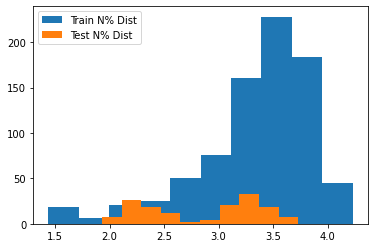

In [21]:
plt.hist(train_n, label = 'Train N% Dist')
plt.hist(test_n, label='Test N% Dist')
plt.legend()

In [41]:
# access r2 and mse scores from validation
print(test_r2)
print(test_mse)

0.48647838830947876
0.13502320300240078
